# Create PairWise Training and Test Set

## Strategy

1. Create a common data frame with 8000*2, 1 label, and n rows of samples. Call this **mainDF**
2. Use **sourceDF** to do a stratified random sampling of the samples so we have even distribution of labels. 
3. Append 2 samples to mainDF and add label based on the samples added
4. Labels: Not Sibblings, Sibblings
5. The label is based on filename again where two samples are sibblings if: XXXXX-RPn everything except n matches. 

### Imports

In [8]:
import pandas as pd
from fileFunctionsModule import importCSVMotifFilesAsDfFromDir
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
import time
from datetime import date
import sys
import os.path
import re

### Data Import & Early Processing to a Single DF

In [9]:
# ! Define variables to be used
rerun_data_compilation = False
data_path = ""
data_type = ""
date_current = str(date.today().isoformat())

# Ask user what kind of data needs to be processed and if data should be recompiled from source csv files. 
while (data_type.lower() not in ['trimer', 'tetramer']) :
    data_type = input('Process Trimer or Tetramer data type?')
    if (input('Would you like to rerun data compilation? Y or N').upper() == 'N'):
        rerun_data_compilation = False
    else:
        rerun_data_compilation = True

if data_type == 'trimer':
    data_path = "../03_SourceFiles/01_TrimerSourceFiles"
elif data_type == 'tetramer':
    data_path = "../03_SourceFiles/02_TetramerSourceFiles"

In [10]:
# Checks if user wants to rerun data compilation. If not, old label file is used from memory
if rerun_data_compilation:
    # Import Data
    # transpose axis of the dataframe:
    # Fill na and nan values with 0 instead
    data_start = importCSVMotifFilesAsDfFromDir(data_path).transpose().reset_index().fillna(0)

    # Rename index column to sampleName in place
    data_start.rename(columns={'index': 'sampleName'}, inplace=True)

    # Add a new column with a binary identifier for a naive vs selected library. i.e = 1 is naive and 0 is selected
    data_start['naiveLibrary'] = data_start.apply(
        lambda row: (('oo' in row.sampleName[10:21]) and
                    ('RN0' in row.sampleName[-6:] or 'RN1' in row.sampleName[-6:])),
        axis=1
    )

    # convert the data in the column (NaiveLibrary) to int type so it is readable
    data_start['naiveLibrary'] = data_start['naiveLibrary'].astype(int)

    if (input('Would you like to save the resulting DF as a csv for future use or overwrite the previously saved csv? Y or N').upper() == 'Y'):
        data_start.to_csv(str('../03_SourceFiles/03_ProcessedFiles/'+data_type+'-combined-labeled.csv'))
        print('DF Structure Saved to file.')
    else:
        pass
elif not rerun_data_compilation:
    if os.path.isfile(str('../03_SourceFiles/03_ProcessedFiles/'+data_type+'-combined-labeled.csv')):
        try:
            data_start = pd.read_csv(
                str('../03_SourceFiles/03_ProcessedFiles/'+data_type+'-combined-labeled.csv'),
                engine='c',
                low_memory=False,
                index_col=0
                )
            print('File read succsessful. Data frame loaded into memory.')
        except:
            print('Something went wrong while trying to read the csv file. Please rerun data compilation or check file manually.')
            sys.exit()
    else:
        print('CSV File does not exist in the source folder (03_SourceFiles/03_ProcessedFiles). Please re-run compilation')


File read succsessful. Data frame loaded into memory.


## Find # of sibblings in data set & separate them out into sibbling groups. 

1. Create a naive and a selected set. 
2. Create two dictionaries: one containing groups of naive sibblings and one for selected sibblings. 
3. Enumerate sets to use for stats later. 

In [11]:
naive_set = data_start[(data_start['naiveLibrary'] == 1)]['sampleName']
selected_set = data_start[~(data_start['naiveLibrary'] == 1)]['sampleName']

### Logic of setting up groups:

1. Set key of dictionary to 20170808-109OOooNA-JB-3_RN**X** where X indicates round. The Primer and Replicate are ommitted
2. Append value of sampleName to list within each diction by matching the key. Use Regular Expressions to create and match key. 

In [12]:
def find_sibbling_groups(data_iterable):
    """
    Creates a dictionary from provided iterable. The iterable should be made up of sampleNames in this format: 
    20170808-109OOooNA-JB-3__R10F5_RN1RP3
    The keys of the dictionary are set to: 20170808-109OOooNA-JB-3_RN1 (The primer and replicate info is removed)
    """
    sibbling_group_dict = {}

    for index, value in data_iterable.items():
        keyID = value.split('__')[0] + '_' + re.findall(r'RN\d{1,}' , value)[0]
        if keyID not in sibbling_group_dict:
            sibbling_group_dict[keyID] = [value]
        else:
            if value not in sibbling_group_dict[keyID]:
                sibbling_group_dict[keyID].append(value)

    return sibbling_group_dict

In [37]:
naive_sibbling_groups = find_sibbling_groups(naive_set)
selected_sibbling_groups = find_sibbling_groups(selected_set)

In [38]:
len(naive_sibbling_groups)

255

In [41]:
# Verify that the data generated is correct:
num_of_single_groups = [] # [Naive, Selected]


def remove_single_member_sibbling_groups(sibbling_group_original):
    sibbling_group = sibbling_group_original.copy()
    single_group_key = []
    single_group_value = []
    empty_group = []
    for key, value in sibbling_group.items():
        if len(value) == 1:
            single_group_value.append(value)
            single_group_key.append(key)
        elif len(value) < 1:
            empty_group.append(key)
    
    for key_ in single_group_key:
        sibbling_group.pop(key_)
    for key_ in empty_group:
        sibbling_group.pop(key_)
    if len(single_group_key) > 0:
        print("Single Groups Found")
    if len(empty_group) > 0:
        print("Empty Groups Found")

    return sibbling_group, single_group_value, empty_group


In [42]:
naive_sibbling_groups, n_s_g, n_e_g = remove_single_member_sibbling_groups(naive_sibbling_groups)

Single Groups Found


In [43]:
len(naive_sibbling_groups)

202

In [44]:
len(n_s_g)

53

In [45]:
len(selected_sibbling_groups)

448

In [46]:
selected_sibbling_groups, s_s_g, s_e_g = remove_single_member_sibbling_groups(selected_sibbling_groups)

Single Groups Found


In [47]:
len(selected_sibbling_groups)

375

In [48]:
len(s_s_g)

73

In [61]:
sampleGroup['20170808-109OOooNA-JB-3_RN1'].append('20170808-109OOooNA-JB-3__R10F5_RN3RP3')

In [60]:
for key, value in naive_sibbling_groups.items():
    print(key, '->', value)
    break

20170808-109OOooNA-JB-3_RN1 -> ['20170808-109OOooNA-JB-3__R10F5_RN1RP3', '20170808-109OOooNA-JB-3__R10F6_RN1RP4', '20170808-109OOooNA-JB-3__R9F1_RN1RP1', '20170808-109OOooNA-JB-3__R9F2_RN1RP2']


In [64]:
sampleGroup, sg, sgv = remove_mismatching_sibbling_groups(sampleGroup)

Mismatches Found


In [65]:
sg

{'20170808-109OOooNA-JB-3_RN1': ['20170808-109OOooNA-JB-3__R10F5_RN1RP3',
  '20170808-109OOooNA-JB-3__R10F6_RN1RP4',
  '20170808-109OOooNA-JB-3__R9F1_RN1RP1',
  '20170808-109OOooNA-JB-3__R9F2_RN1RP2',
  '20170808-109OOooNA-JB-3__R10F5_RN3RP3']}

In [66]:
sgv

['20170808-109OOooNA-JB-3__R10F5_RN3RP3']

In [57]:
sampleGroup = naive_sibbling_groups.copy()

In [63]:
def remove_mismatching_sibbling_groups(sibbling_group_original):
    sibbling_group = sibbling_group_original.copy()
    mismatching_groups ={}
    mismatching_group_values = []
    for key, value in sibbling_group.items():
        group_id = re.findall(r'RN\d{1,}', key)[0]
        for sample in value:
            if group_id != re.findall(r'RN\d{1,}', sample)[0]:
                mismatching_groups[key] = value
                mismatching_group_values.append(sample)

    for key in mismatching_groups:
        sibbling_group.pop(key)

    if len(mismatching_groups) > 0:
        print('Mismatches Found')

    return sibbling_group, mismatching_groups, mismatching_group_values

In [52]:
naive_sibbling_groups, n_m_g, n_m_g_v = remove_mismatching_sibbling_groups(naive_sibbling_groups)

In [56]:
n_m_g_v

[]

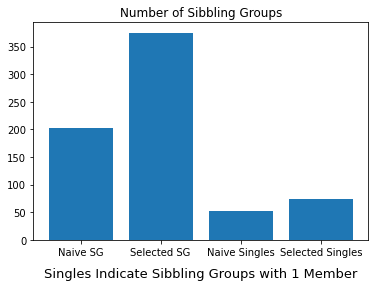

In [78]:
labels_bar_sibblings = ['Naive SG', 'Selected SG', 'Naive Singles', 'Selected Singles']
data_bar_sibblings = [
    len(naive_sibbling_groups), 
    len(selected_sibbling_groups),
    len(n_s_g),
    len(s_s_g)
    ]
plt.bar(labels_bar_sibblings, data_bar_sibblings)
plt.title('Number of Sibbling Groups')
plt.xlabel('Singles Indicate Sibbling Groups with 1 Member',fontdict={
    'weight':'normal',
    'size':'13'
},  labelpad=10)

plt.savefig('sibbling-groups-distribution-august-5.png', bbox_inches='tight')

### Create a general df with this structure:

1. SampleName_1_^_SampleName_2 | Motifs_1 | Motifs_1 | Sibbling
2. Create new record for every permutation and append to DF with a label

In [79]:
data_start

,sampleName,TYA,LDV,AWL,WLD,YAW,HQH,SGQ,DHQ,GQD,...,WEC,WIC,WMC,CFW,EMC,FCM,CWW,WWC,CWV,naiveLibrary
0,20160602-07ABsaGN-OO-3__R2F3_RN1RP1,117404.0,117293.0,117027.0,116979.0,116949.0,51752.0,51567.0,51530.0,51492.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,20170808-109OOooNA-JB-3__R10F5_RN1RP3,36.0,0.0,1.0,67.0,1.0,4.0,58.0,16.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20170808-109OOooNA-JB-3__R10F6_RN1RP4,52.0,0.0,7.0,3.0,8.0,37.0,21.0,8.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20170808-109OOooNA-JB-3__R9F1_RN1RP1,55.0,31.0,1.0,5.0,13.0,37.0,47.0,5.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,20170808-109OOooNA-JB-3__R9F2_RN1RP2,205.0,0.0,0.0,1.0,2.0,84.0,1.0,21.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,20170228-23ARooOO-HD-3__R8F3_RN1RP4,70.0,7.0,1.0,24.0,17.0,86.0,6.0,20.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2393,20171106-130OOicXP-JW-3__R10F15_RN6RP4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2394,20170202-71MZdcEB-DF-3__R7F1_RN1RP1,617.0,491.0,317.0,307.0,275.0,228.0,313.0,196.0,228.0,...,6.0,3.0,3.0,4.0,11.0,8.0,1.0,3.0,5.0,0
2395,20170202-71MZdcEB-DF-3__R7F2_RN1RP2,569.0,456.0,323.0,282.0,260.0,229.0,312.0,197.0,206.0,...,4.0,8.0,1.0,3.0,7.0,6.0,2.0,0.0,5.0,0


In [86]:
columns_start = data_start.columns
columns_1 = [column_name +'_1' for column_name in columns_start]
columns_2 = [column_name +'_2' for column_name in columns_start]


In [87]:
df_pairwise_start = pd.DataFrame(columns=columns_1+columns_2)

In [88]:
df_pairwise_start

,sampleName_1,TYA_1,LDV_1,AWL_1,WLD_1,YAW_1,HQH_1,SGQ_1,DHQ_1,GQD_1,...,WEC_2,WIC_2,WMC_2,CFW_2,EMC_2,FCM_2,CWW_2,WWC_2,CWV_2,naiveLibrary_2


Couple of ways of doing this:

1. Add combined record to new DF
2. Create two DFs, add left and right records as per the iterator in the correct order. Then rename the columns in each axis with _1 and _2. Combine the two on axis =1. Create one more df with combined name and label. 
